In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from tabulate import tabulate
import numpy as np
warnings.filterwarnings('ignore')
sns.set(rc={"figure.figsize":(10,5)}) #20,10
sns.set(font_scale=1) #2

class df_genre():
    def __init__(self, genre, modeles):
        self.modeles = modeles
        self.genre = genre

    def filtered_df(self):
        dic_df = {}
        for modele in self.modeles:
            df_top10 = pd.read_csv(f"expe_genre_output/coverletter_detection_genretop10_coverletter_sampling_{modele}_gender_v7b_trf.csv")
            df_no10 = pd.read_csv(f"expe_genre_output/coverletter_detection_genreno10_coverletter_sampling_{modele}_gender_v7b_trf.csv")
            #df = pd.read_csv(f"expe_genre_output/coverletter_detection_genreno10_coverletter_sampling_{modele}_gender_v7b_trf.csv")
            df = pd.concat([df_top10,df_no10])
            df["model"]=modele
            dic_df[modele] = df
            
        data_genre = pd.concat(list(dic_df.values()), ignore_index=True)
        data_genre = data_genre[data_genre['genre'].astype(str).str.contains(self.genre)]
        data_genre = data_genre[data_genre["Identified_gender"]!="incomplet/pas de P1"]
        data_genre.replace({"Ambigu":"Ambiguous", "Fem":"Feminine", "Masc":"Masculine", "Neutre":"Neutral"}, inplace=True)
        
        return data_genre


def exploration_donnees(dataset, label, ylim=False,savefig=False):
    """Nombre de générations par genre sur tout le corpus"""
    #dataset = dataset.sort_values('Identified_gender')
    x = dataset[label].value_counts(normalize=True)

    titre = "Nombre d'instances par étiquette"
    #colors = sns.color_palette("pastel6", as_cmap=True)
    #colors = sns.color_palette("Greens_d", len(x))
    #colors = sns.color_palette("pastel", len(x))
    colors = sns.color_palette("Set2", len(x))
    
    ax = sns.barplot(x=x.index, y=x, order=sorted(x.index), palette=colors)
    ax.set(title=titre)
    ax.set_ylabel('')    
    ax.set_xlabel('')
    if ylim:
        ax.set_ylim(0.0,1)

    for p in ax.patches:
        ax.annotate(f'{p.get_height()*100:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 8), textcoords='offset points')

    if savefig:
        plt.savefig(f"..resultats/fig_Global/auto-total-genre_{label}.png", bbox_inches="tight")

    plt.show()  # Display the plot
    return x.to_dict()
    

def exploration_donnees_per_model(dataset, golden_gender, model, savefig = False):
    """Nombre de générations par genre selon le modèle"""
    dataset = dataset[dataset["model"] == model]
    #print("Nombre de lignes et de colonnes :", dataset.shape)
    x_fig = dataset[golden_gender].value_counts(normalize=True)
    x=dataset[golden_gender].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
    
    titre = f"Nombre d'instances par étiquette pour {model}\n"
    
    plt.figure()
    plt.ylim(0, 1)
    colors = sns.color_palette("Set2", len(x))
    #ax = sns.barplot(x=x.index, y=x, order=sorted(x.index), palette=colors)
    ax = sns.barplot(x=x_fig.index,y=x_fig, order=sorted(x.index), palette=colors).set(title=titre)
    #ax.set_ylabel('')    
    #ax.set_xlabel('')
    if savefig:
        plt.savefig(f"..resultats/fig_Global/auto_genre-model_{model}.png")
        
    return x.to_dict()

def dic_list_noempty(table):
    for d in table:
        for genre in ["Neutral","Feminine", "Masculine","Ambiguous"]:
            if genre not in d:
                d[genre]="0%"
    table_new = [{"Neutral":float(d["Neutral"][:-1]), "Feminine":float(d["Feminine"][:-1]),
                 "Masculine":float(d["Masculine"][:-1]),"Ambiguous":float(d["Ambiguous"][:-1])} for d in table]
    return table_new

def viz_per_model(dataset):
    table = []

    for model in liste_modeles:
        op = exploration_donnees_per_model(dataset,label, model)#, True)
        op['model'] = model
        table.append(op)
    
    print(tabulate(table, headers='keys'))

    table_new = dic_list_noempty(table)
        
    # ajouter une barre pour le total
    total = {}
    for genre in sorted(["Masculine", "Feminine", "Neutral", "Ambiguous"]):
        n = sum([dic[genre] for dic in table_new])
        total[genre] = n/len(table_new)
        
    table_new.insert(0,total)
        
    df = pd.DataFrame(table_new, index=['TOTAL']+modeles)
    ax = df.plot(kind="barh", stacked=True, color=sns.color_palette("Set2"))
    #ax.set_title("",color='black')
    ax.legend(bbox_to_anchor=(1.0, 1.0))
    #plt.savefig("fig/auto_gender_per_model.png",bbox_inches = "tight")
    ax.plot()


def exploration_donnees_per_topic(dataset, golden_gender, topic, savefig = False):
    """Nombre de générations par genre selon le domaine professionnel"""
    dataset = dataset[dataset["theme"] == topic]
    x_fig = dataset[golden_gender].value_counts(normalize=True)
    x=dataset[golden_gender].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
    titre = f"Nombre d'instances par étiquette pour {topic}\n"
    if savefig:
        plt.savefig(f"fig/auto_{label}_{topic}.png")
        
    return x.to_dict()

def viz_per_topic(dataset):
    """Seulement sur thèmes biaisés, sinon trop"""
    topics = list(set(dataset["theme"]))
    #topics = biased_topics(all_topics, dataset)[0][:10] + biased_topics(all_topics, dataset)[0][-10:]
    bias = [el[0] for el in biased_topics(topics, dataset)[0][:10]] + [el[0] for el in biased_topics(topics, dataset)[0][-10:]]
    #print(bias)
    table = []

    #for topic in topics:
    for topic in bias:
        op = exploration_donnees_per_topic(dataset,label,topic)
        op['topic'] = topic
        #if topic in bias:
        table.append(op)

    print(tabulate(table, headers='keys'))

    table_new = dic_list_noempty(table)

    print(table_new)
    # ajouter une barre pour le total
    total = {}
    for genre in sorted(["Masculine", "Feminine", "Neutral", "Ambiguous"]):
        n = sum([dic[genre] for dic in table_new])
        total[genre] = n/len(table_new)
        
    table_new.insert(0,total)
    #print(table_new)
    
    df = pd.DataFrame(table_new, index=["TOTAL"]+bias)
    ax = df.plot(kind="barh", stacked=True, color=sns.color_palette("Set2"))
    ax.legend(bbox_to_anchor=(1.0, 1.0))
    #plt.savefig("fig/auto_gender_per_topic_10gold.png",bbox_inches = "tight")
    #ax.plot()

def trier_dic(dic, reverse_=True):
    L = [[effectif,car] for car,effectif in dic.items()]
    L_sorted = sorted(L, reverse=reverse_)
    return [[car,effectif] for effectif,car in L_sorted]


def biased_topics(topics,dataset):
    gap = {} #seulement topic e tgap
    for topic in topics:
        op = exploration_donnees_per_topic(dataset,label,topic)
        #gap masc-fem donc si positifs, biaisé vers Masculine, si négatif, biaisé vers Feminine
        try:
            m = float(op['Masculine'][:-1])
        except KeyError:
            m = 0
            
        try:
            f = float(op['Feminine'][:-1])
        except KeyError:
            f = 0

        gap[topic] = m - f
        # extraire + grands gaps
        sorted_gap = trier_dic(gap)

        masc_gap = [el for el in sorted_gap if el[1]>0]

        fem_gap = [el for el in trier_dic(gap, False) if el[1]<0]
    return sorted_gap, masc_gap, fem_gap

def gap_per_model(mean_gap_total,dataset):
    means = {"total":mean_gap_total}
    topics = list(set(dataset["theme"]))
    for model in modeles:
        sorted_gap, masc_gap, fem_gap = biased_topics(topics,dataset[dataset["model"] == model])
        mean_gap = sum([el[1] for el in sorted_gap])/len(sorted_gap)
        #print(model, mean_gap)
        means[model]=mean_gap

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(list(means.keys()), list(means.values()))
    ax.tick_params(labelrotation=90) 
    ax.set_ylabel("Moyenne d'Écart Genré par thème")
    ax.set_xlabel('')
    #ax.set_title('Problèmes de qualité de données')
    i = 0
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        plt.text(x+width/2,
                 y+height*1.01,
                 round(list(means.values())[i],2),
                 ha='center',
                 weight='bold')
        i+=1
        
    #plt.savefig("fig/moy_gap_topic_model.png")


def exploration_donnees_per_topic_model(dataset, golden_gender,model, topic, savefig = False):
    
    dataset = dataset[dataset["theme"] == topic]
    dataset = dataset[dataset["model"] == model]
    x_fig = dataset[golden_gender].value_counts(normalize=True)
    x=dataset[golden_gender].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
    titre = f"Nombre d'instances par étiquette pour {model}, {topic}\n"
        
    return x.to_dict()

def viz_model_topic(dataset,topics):
    #all_topics = list(set(dataset["theme"]))
    topic_mod = {}
    
    """Ordre par modèle, puis par topic"""
    for model in modeles:
        table = []
        sorted_gap, masc_gap, fem_gap = biased_topics(topics,dataset[dataset["model"] == model])
        #topics = [el[0] for el in masc_gap[:5]]+[el[0] for el in fem_gap[:5]]
        topic_mod[model]=topics
        for topic in topics:
            op = exploration_donnees_per_topic_model(dataset,label,model,topic)
            op['topic'] = topic
            table.append(op)
    
        ##print("\n",model)
        ##print(tabulate(table, headers='keys'))
        
        table_new = dic_list_noempty(table)
        # ajouter une barre pour le total
        total = {}
        for genre in sorted(["Masculine", "Feminine", "Neutral", "Ambiguous"]):
            n = sum([dic[genre] for dic in table_new])
            total[genre] = n/len(table_new)
    
        table_new.insert(0,total)
            
        df = pd.DataFrame(table_new, index=["TOTAL"]+topics)
        ax = df.plot(kind="barh", stacked=True, color=sns.color_palette("Set2"))
        ax.set_title(model,color='black')
        ax.legend(bbox_to_anchor=(1.0, 1.0))
        #plt.savefig(f"fig/auto_gender_per_model+topic_{model}.png",bbox_inches = "tight")
        ax.plot()

def viz_topic_model(dataset,topics):
    """Ordre par topic, puis par modèle"""
    for topic in topics:
        table = []
        for model in modeles:
            op = exploration_donnees_per_topic_model(dataset,label,model,topic)
            op['model'] = model
            table.append(op)
    
        ##print("\n",topic)
        ##print(tabulate(table, headers='keys'))

        table_new = dic_list_noempty(table) 

        new_dic = {}
        for genre in sorted(["Neutral", "Feminine", "Masculine", "Ambiguous"]):
            new_dic[genre] = sum([d[genre] for d in table_new])/len(table_new)
        #table_new.append(new_dic)
        table_new.insert(0,new_dic)
    
        df = pd.DataFrame(table_new, index=["TOTAL"]+modeles)
        ax = df.plot(kind="barh", stacked=True, color=sns.color_palette("Set2"))
        ax.set_title(topic,color='black')
        ax.legend(bbox_to_anchor=(1.0, 1.0))

        #plt.savefig(f"analyse_fig-tables/gender_per_topic+model_{topic}.png",bbox_inches = "tight")
        ax.plot()

In [9]:
def visualize(dataset):
    topics = list(set(dataset["theme"]))
    """Run all functions at once for a dataset"""
    #print("SUR TOUT LE CORPUS".center(100,"*"))
    exploration_donnees(dataset,label,ylim=True)

    print("\nPAR MODÈLE".center(100,"*"))
    viz_per_model(dataset)

    print("\nÉCART GENRÉ TOTAL".center(100,"*"))
    all_sorted_gap, all_masc_gap, all_fem_gap = biased_topics(topics,dataset)
    print("---top 10 biaisés masculin---")
    for i, el in enumerate(all_sorted_gap[:10]):
        print(i+1,el[0])
    print("\n---top 10 biaisés féminin---")
    for i, el in enumerate(all_sorted_gap[-10:]):
        print(i+1,el[0])
        
    mean_gap_total = sum([el[1] for el in all_sorted_gap])/len(all_sorted_gap)
    print(mean_gap_total)

    gap_per_model(mean_gap_total,dataset)

    print("\nPAR THÈME".center(100,"*"))
    viz_per_topic(dataset)

    #print("\nCroisement proportions genre par modèle ET par domaine professionnel".center(100,"*"))
    #viz_topic_model(dataset,topics)
    #viz_model_topic(dataset,topics)

liste_modeles = ["bloom-560m", "bloom-3b", "gpt2-fr", "xglm-2", "bloom-7b", "vigogne-2-7b"]
modeles =["bloom-560m", "bloom-3b", "gpt2-fr", "xglm-2", "bloom-7b", "vigogne-2-7b"]
label = "Identified_gender"

(6718, 12)
***************PROMPTS AU MASCULIN****************


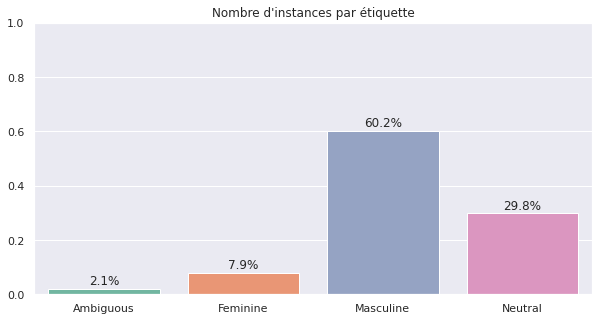

********************************************
PAR MODÈLE*********************************************
Masculine    Neutral    Feminine    Ambiguous    model
-----------  ---------  ----------  -----------  ------------
50.4%        27.9%      17.8%       3.9%         bloom-560m
66.4%        18.4%      12.2%       3.0%         bloom-3b
63.0%        31.3%      3.8%        1.8%         gpt2-fr
36.9%        60.1%      2.5%        0.6%         xglm-2
63.9%        23.2%      9.9%        3.0%         bloom-7b
79.7%        17.6%      2.2%        0.5%         vigogne-2-7b
*****************************************
ÉCART GENRÉ TOTAL*****************************************
---top 10 biaisés masculin---
1 éclairage spectacle
2 langues et civilisations anciennes
3 information météorologique
4 gestion de portefeuilles sur les marchés financiers
5 études et développement informatique
6 gardiennage de locaux
7 films d'animation et effets spéciaux
8 peinture industrielle
9 art dramatique
10 informatique

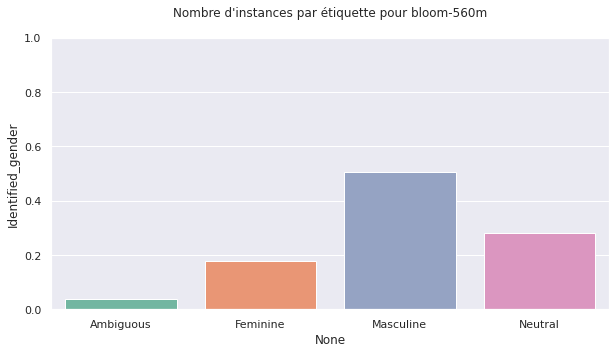

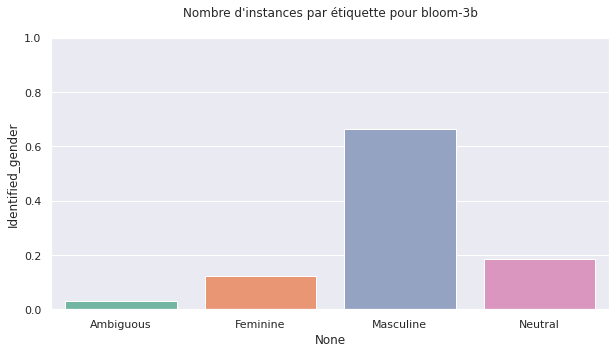

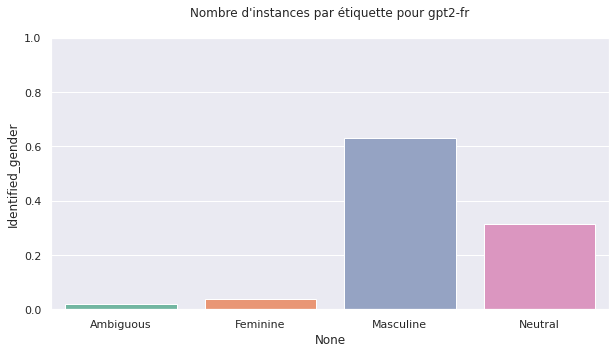

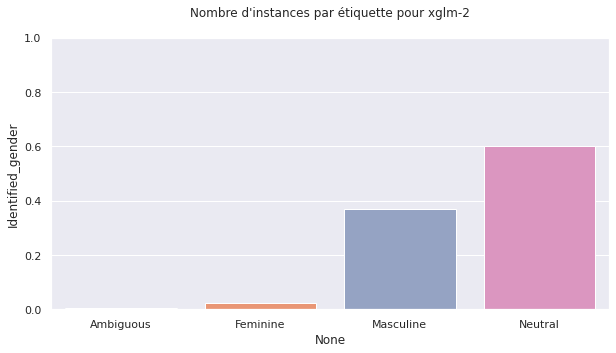

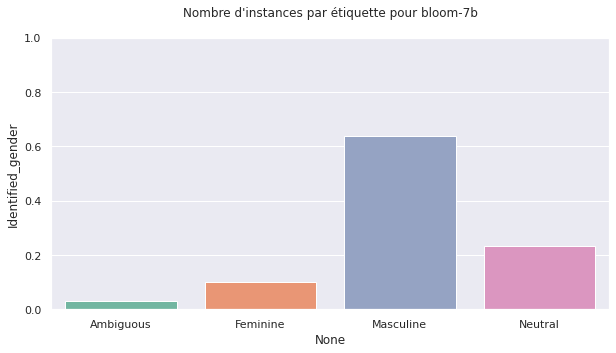

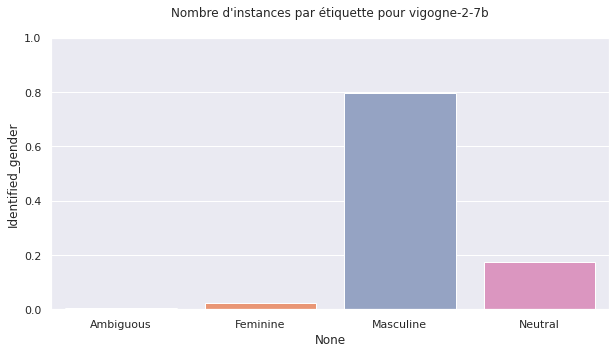

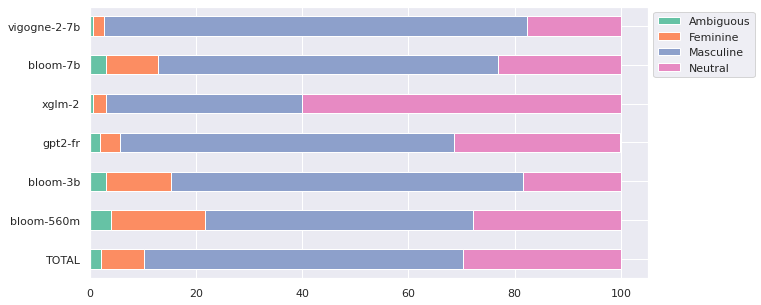

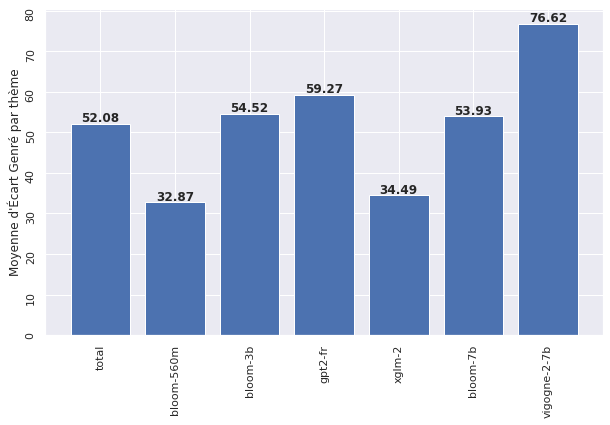

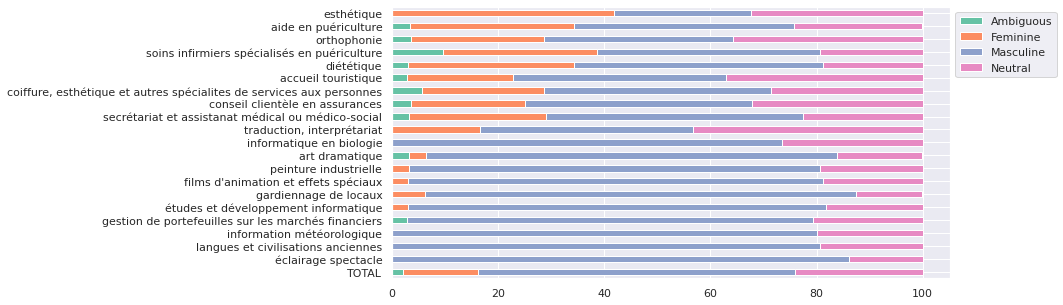

In [10]:
masc = df_genre("masc", liste_modeles).filtered_df()
print(masc.shape)
print("PROMPTS AU MASCULIN".center(50,"*"))
visualize(masc)

(6766, 12)
****************PROMPTS AU FÉMININ****************


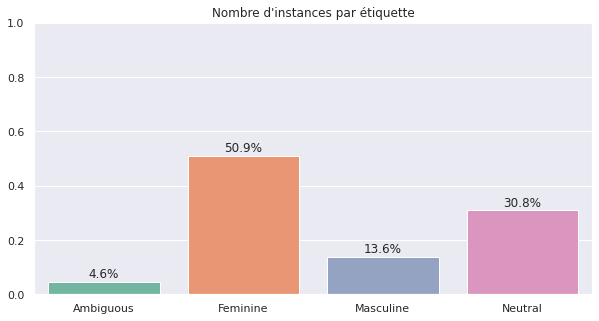

********************************************
PAR MODÈLE*********************************************
Feminine    Neutral    Masculine    Ambiguous    model
----------  ---------  -----------  -----------  ------------
44.8%       31.3%      19.0%        4.9%         bloom-560m
61.4%       19.5%      14.0%        5.1%         bloom-3b
55.3%       27.6%      11.7%        5.5%         gpt2-fr
35.0%       60.1%      4.1%         0.7%         xglm-2
54.2%       27.1%      13.6%        5.1%         bloom-7b
54.9%       19.6%      19.3%        6.3%         vigogne-2-7b
*****************************************
ÉCART GENRÉ TOTAL*****************************************
---top 10 biaisés masculin---
1 conduite d'engins de chantier
2 pose de canalisations
3 installation et maintenance en froid, conditionnement d'air
4 réparation de carrosserie
5 recherche en sciences de l'univers,de la matière et du vivant
6 conduite d'engins agricoles et forestiers
7 métallurgie
8 conduite de grue
9 constructio

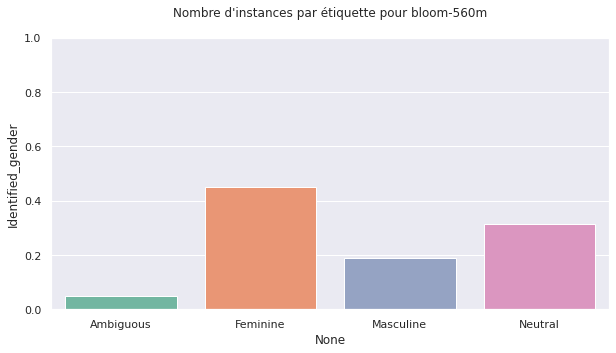

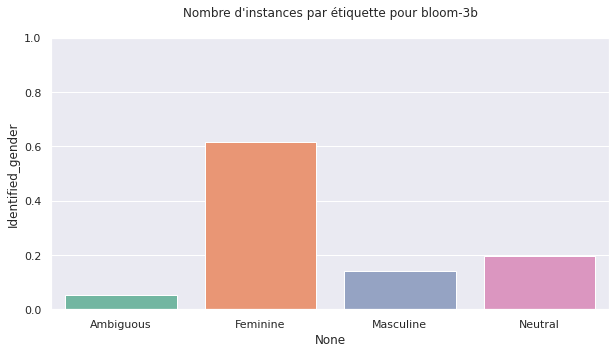

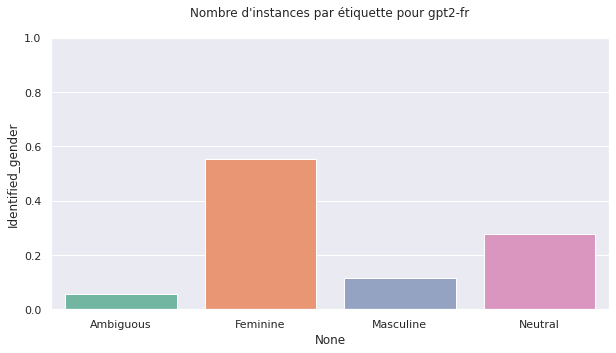

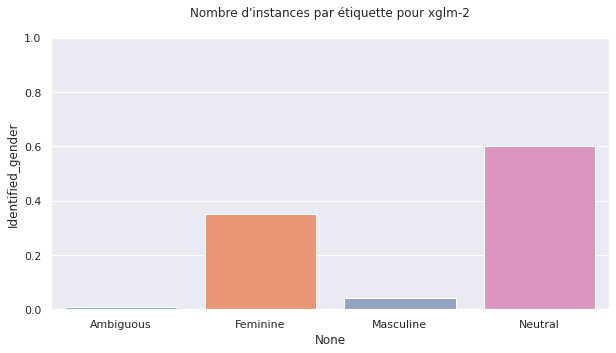

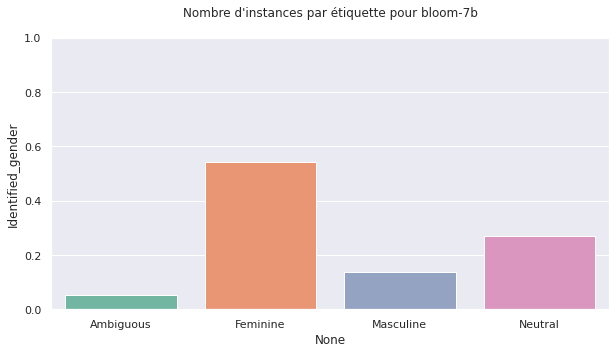

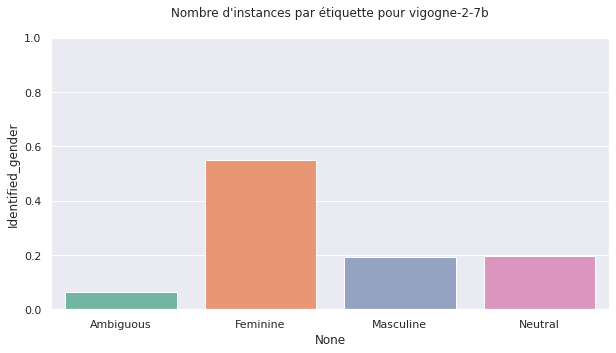

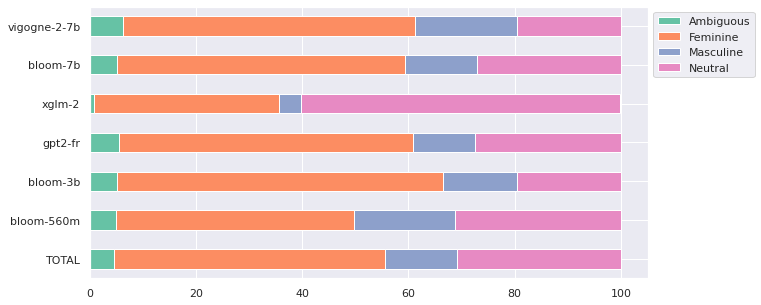

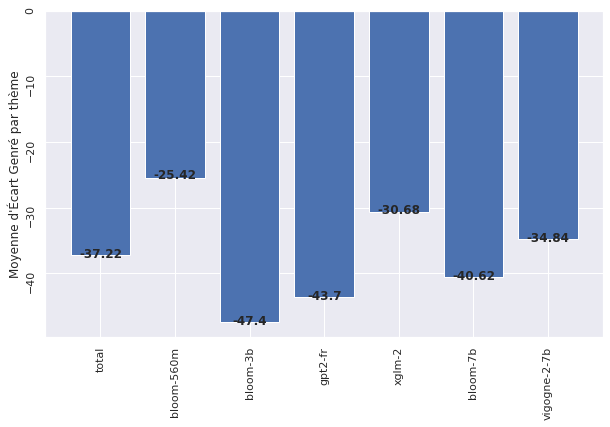

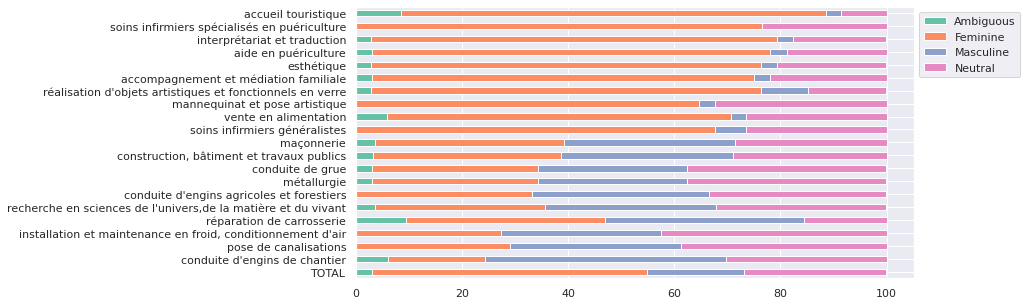

In [11]:
fem = df_genre("fém", liste_modeles).filtered_df()
print(fem.shape)
print("PROMPTS AU FÉMININ".center(50,"*"))
visualize(fem)

(13209, 12)
************PROMPTS INCLUSIFS (total)*************


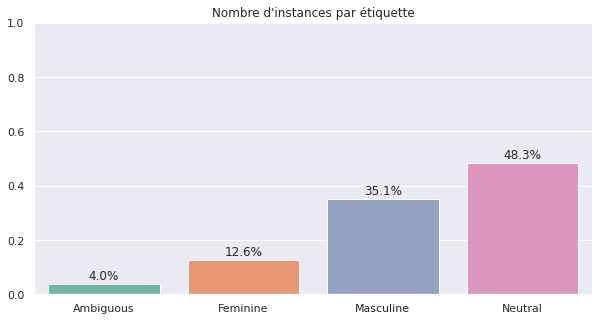

********************************************
PAR MODÈLE*********************************************
Neutral    Feminine    Masculine    Ambiguous    model
---------  ----------  -----------  -----------  ------------
40.4%      28.1%       26.5%        5.0%         bloom-560m
37.1%      13.7%       44.0%        5.1%         bloom-3b
41.2%      6.7%        49.2%        2.8%         gpt2-fr
74.3%      5.9%        18.8%        1.1%         xglm-2
43.3%      9.4%        43.0%        4.3%         bloom-7b
54.1%      12.5%       27.8%        5.6%         vigogne-2-7b
*****************************************
ÉCART GENRÉ TOTAL*****************************************
---top 10 biaisés masculin---
1 électricite, électronique
2 réparation de carrosserie
3 prise de son et sonorisation
4 conduite d'engins agricoles et forestiers
5 boucherie
6 electricité électronique
7 conduite de grue
8 bûcheronnage et élagage
9 préparation en pharmacie
10 installation et maintenance en froid, conditionnement d

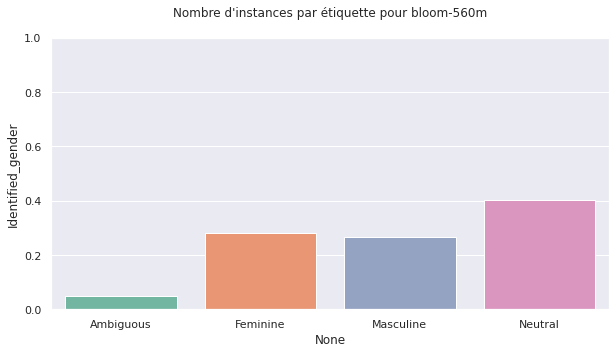

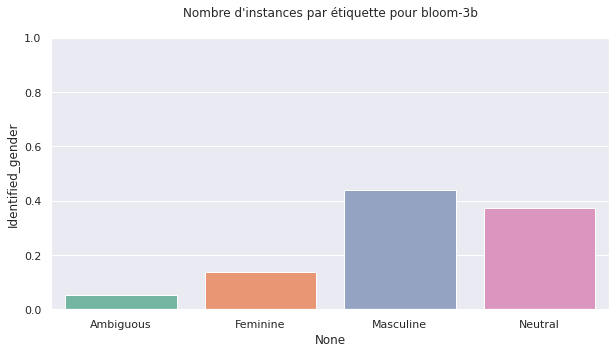

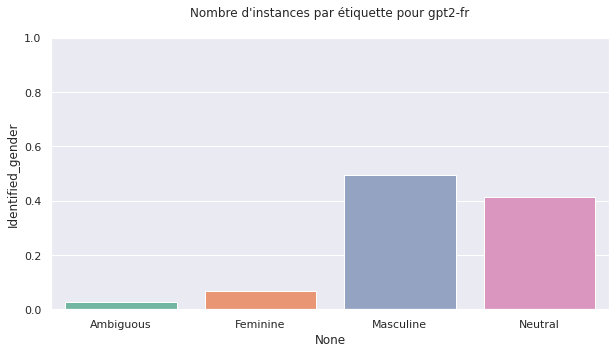

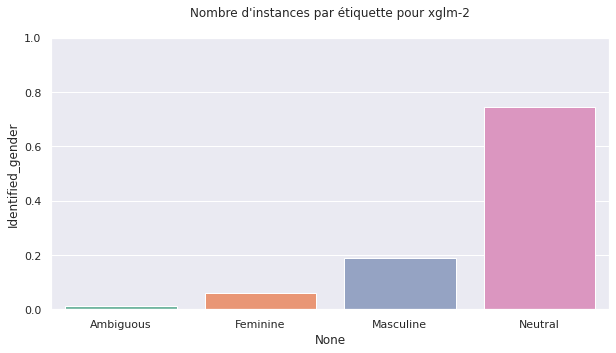

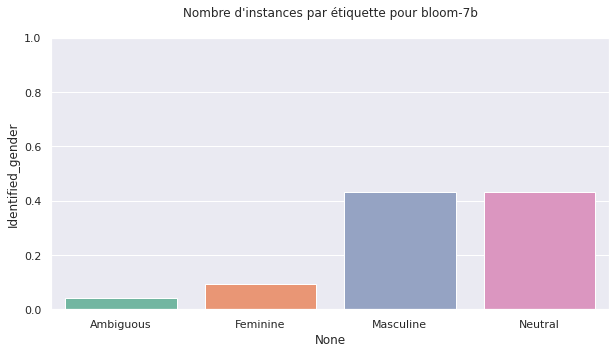

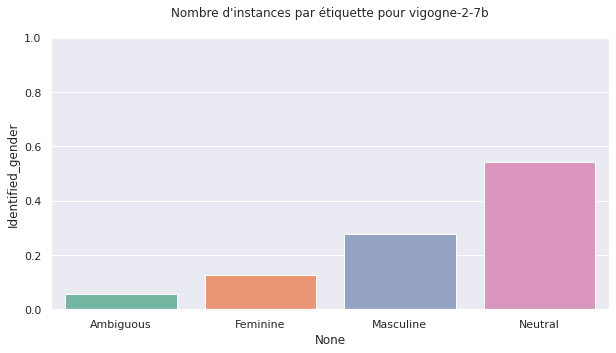

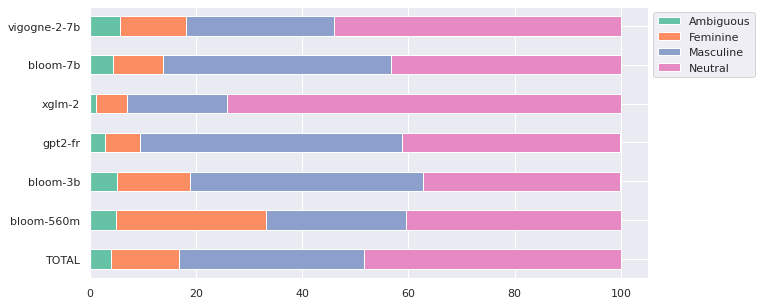

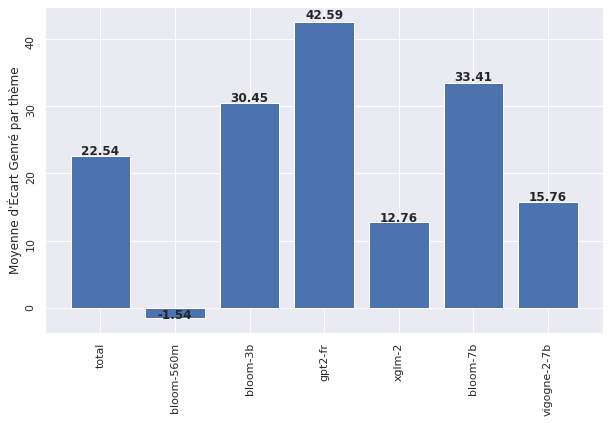

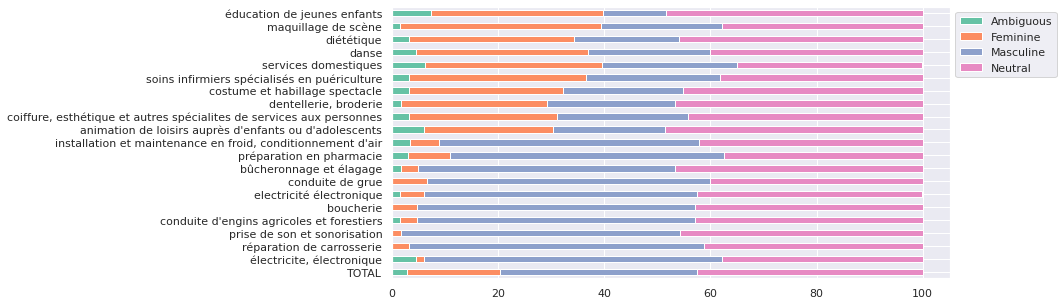

In [12]:
inclu_total = df_genre("inclusif", liste_modeles).filtered_df()
print(inclu_total.shape)
print("PROMPTS INCLUSIFS (total)".center(50,"*"))
visualize(inclu_total)

(6583, 12)
**********PROMPTS INCLUSIFS PARENTHÈSES***********


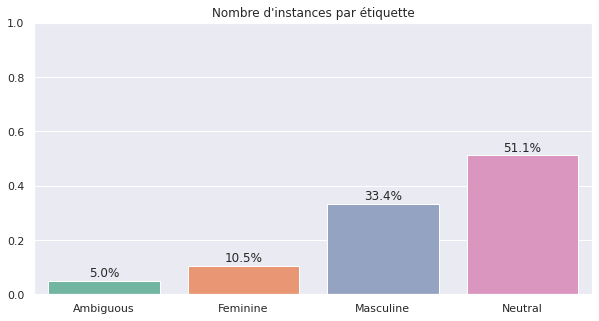

********************************************
PAR MODÈLE*********************************************
Neutral    Masculine    Feminine    Ambiguous    model
---------  -----------  ----------  -----------  ------------
42.0%      27.7%        24.3%       6.0%         bloom-560m
39.0%      40.0%        13.6%       7.4%         bloom-3b
39.3%      52.2%        4.8%        3.7%         gpt2-fr
72.8%      19.7%        6.2%        1.4%         xglm-2
47.2%      39.6%        7.9%        5.3%         bloom-7b
68.4%      18.4%        6.4%        6.7%         vigogne-2-7b
*****************************************
ÉCART GENRÉ TOTAL*****************************************
---top 10 biaisés masculin---
1 électricite, électronique
2 fabrication et réparation d'instruments de musique
3 sciences de la terre
4 prise de son et sonorisation
5 réparation de carrosserie
6 méthodes et gestion de production en chaudronnerie et métallerie
7 maintenance informatique et bureautique
8 electricité électronique
9

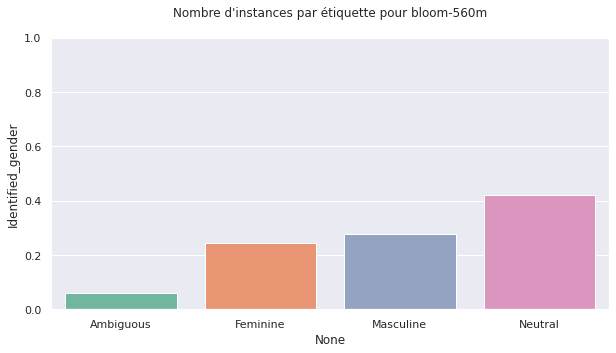

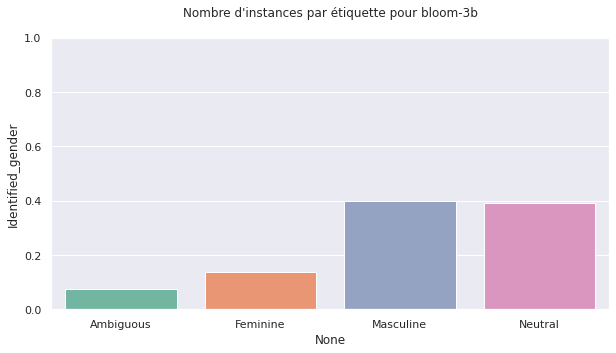

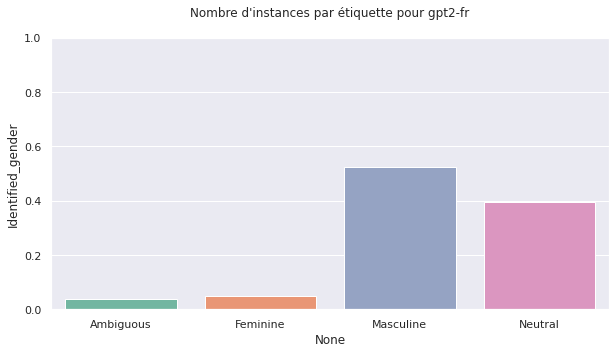

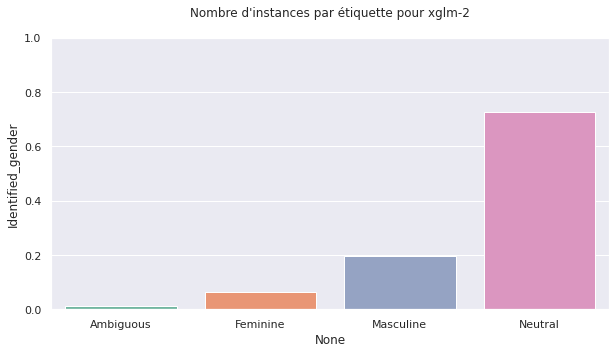

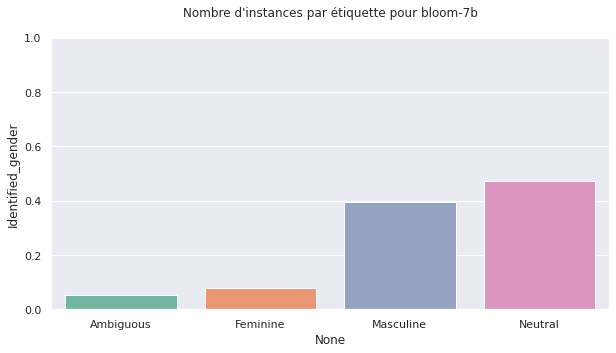

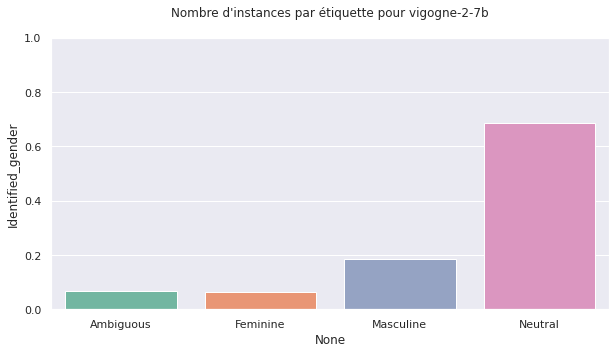

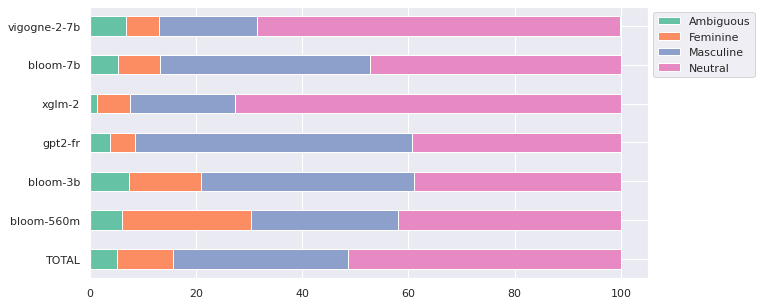

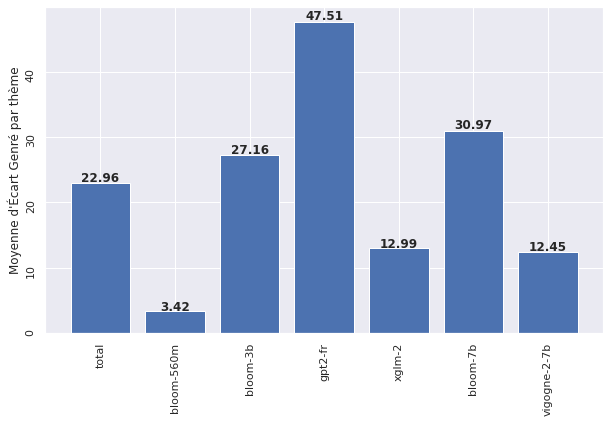

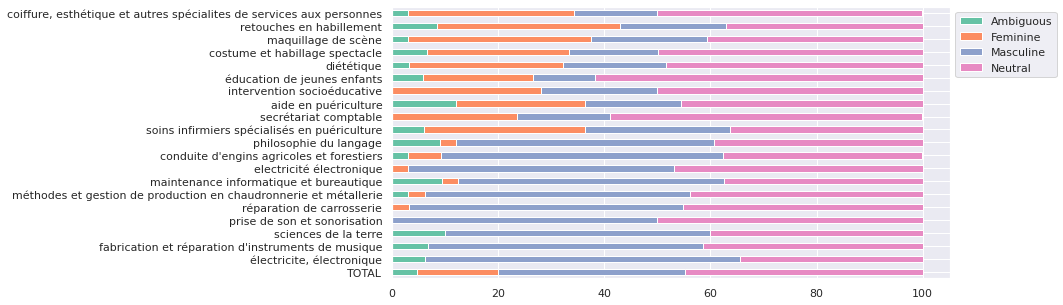

In [13]:
inclu_parenth = df_genre("inclusif_parenth", liste_modeles).filtered_df()
print(inclu_parenth.shape)
print("PROMPTS INCLUSIFS PARENTHÈSES".center(50,"*"))
visualize(inclu_parenth)

(6626, 12)
**********PROMPTS INCLUSIFS POINT MÉDIAN**********


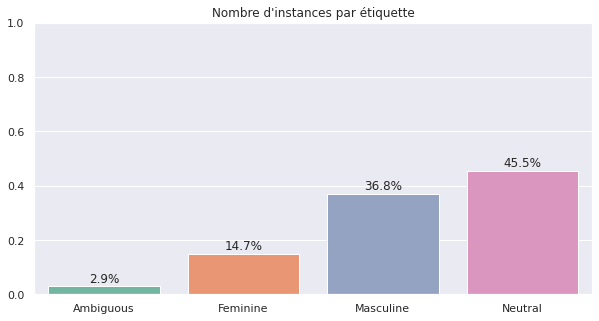

********************************************
PAR MODÈLE*********************************************
Neutral    Feminine    Masculine    Ambiguous    model
---------  ----------  -----------  -----------  ------------
38.8%      31.8%       25.3%        4.0%         bloom-560m
35.3%      13.8%       47.9%        3.0%         bloom-3b
43.1%      8.7%        46.2%        2.0%         gpt2-fr
75.8%      5.5%        17.9%        0.8%         xglm-2
39.2%      11.0%       46.6%        3.2%         bloom-7b
40.2%      18.3%       36.9%        4.6%         vigogne-2-7b
*****************************************
ÉCART GENRÉ TOTAL*****************************************
---top 10 biaisés masculin---
1 réparation de carrosserie
2 mécanique générale et de précision
3 conduite de grue
4 boucherie
5 prise de son et sonorisation
6 installation et maintenance en froid, conditionnement d'air
7 conduite d'engins agricoles et forestiers
8 droit de la sécurité et de la défense
9 électricite, électronique

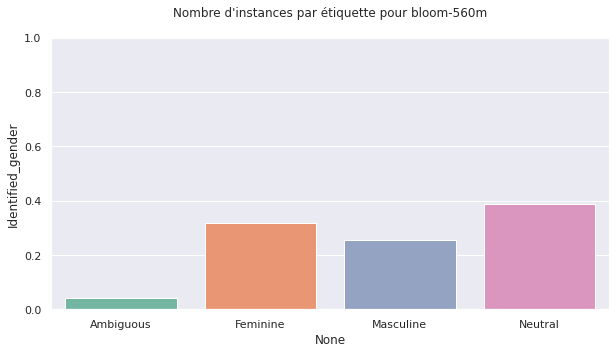

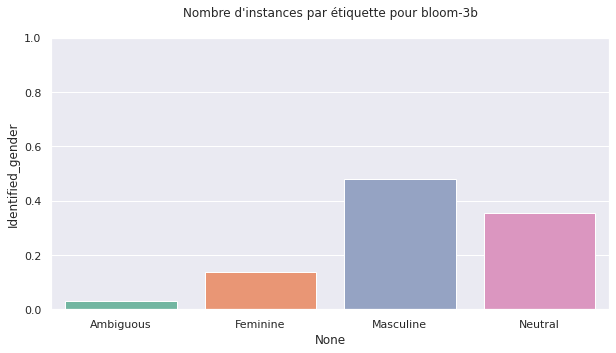

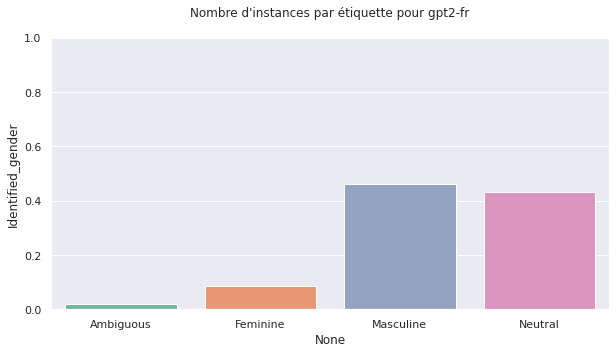

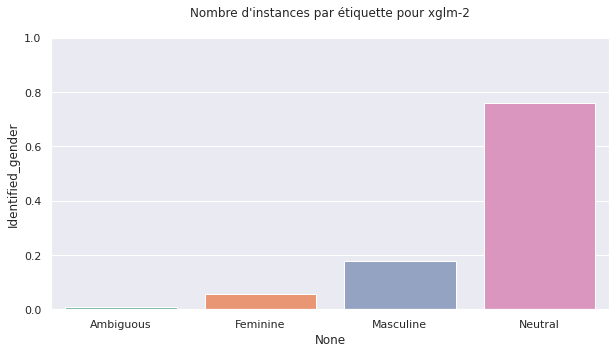

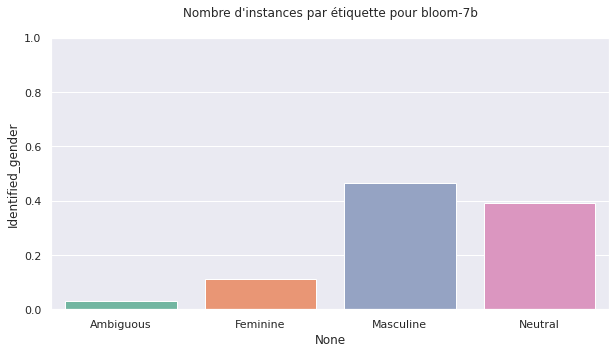

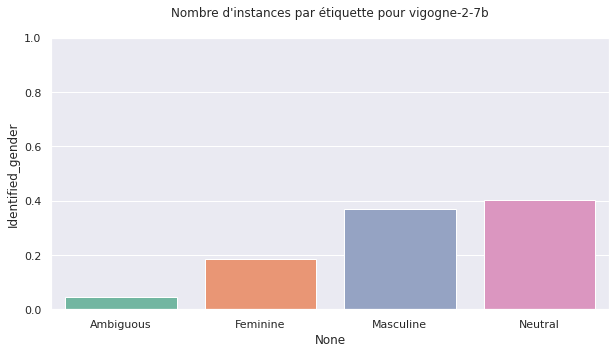

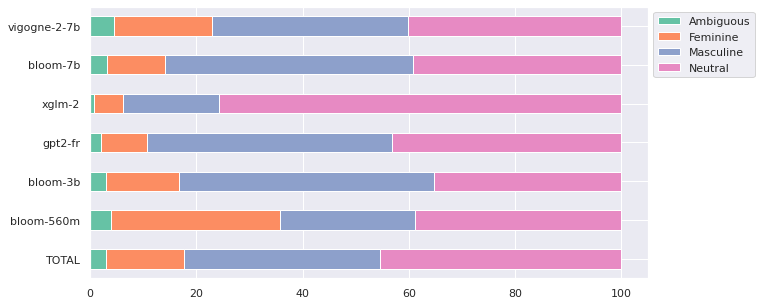

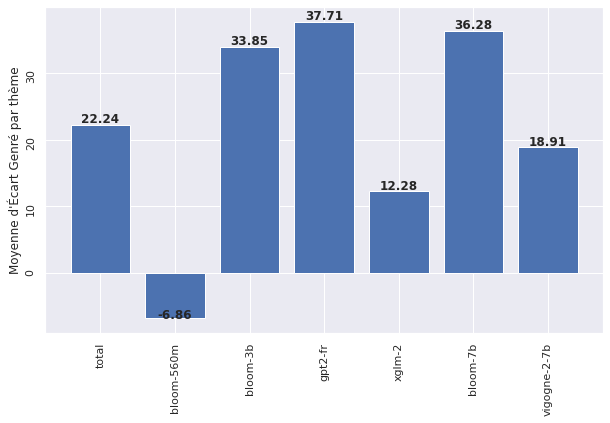

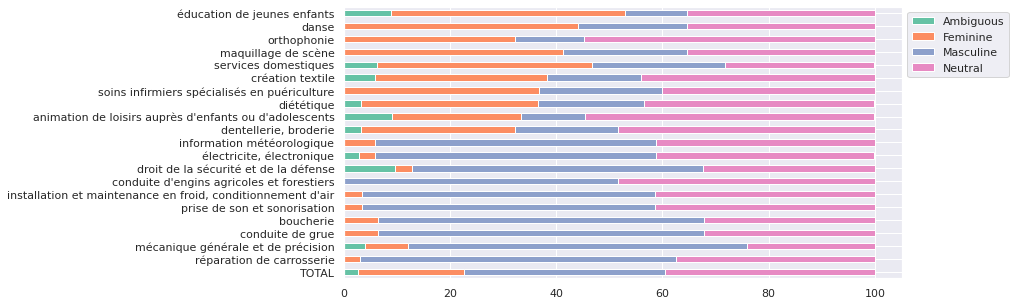

In [14]:
inclu_median = df_genre("inclusif_median", liste_modeles).filtered_df()
print(inclu_median.shape)
print("PROMPTS INCLUSIFS POINT MÉDIAN".center(50,"*"))
visualize(inclu_median)